# Reversed condition

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from numpy.linalg import matrix_rank, svd
import sys
sys.path.append('../')
from test_data import experiment_data,add_noise,create_data_2d
from error_bounds import *

Instead of looking at the condition it might be sensible to look at the reversed condition function
$$h(A):= \frac{\sigma_n}{\sigma_1} \geq \frac{\sigma_n}{\|A\|_F} := g(A)$$
We do not consider the supremum here. This might only be an approximation of a true uppper bound.

### What is the ratio between the smallest and biggest singular value?

The idea is if $A \in \mathbb{R}^{nxm}$ for $m<n$ has full rank $C>\frac{\sigma_m}{\sigma_1} > 0$ for some $C>0$, but if it does not have full rank $\frac{\sigma_m}{\sigma_1} \approx 0$

If we assume that the relative condition can bound our problem, then we have:
\begin{equation}
    | \frac{\sigma_n(A+E)}{\sigma_1(A+E)} - \frac{\sigma_n(A)}{\sigma_1(A)} | < (\frac{1}{\sigma_1}^2+\frac{\sigma_n}{\sigma_1^2}^2)\|E\|_F
\end{equation}
and
\begin{equation}
    | \frac{\sigma_n(A+E)}{\|A+E\|_F} - \frac{\sigma_n(A)}{\|A\|_F} | < (\frac{1}{\|A\|_F}+\frac{\sigma_n(A)}{\|A\|_F^2}) \ \|E\|_F
\end{equation}

In [4]:
"""
This calculates o_n/o_1
"""
def reverse_condition(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/sv[0]
    
"""
This calculates o_n/Frobenius_norm(A)
"""    
def reverse_condition_approx(A):
    sv = svd(A, compute_uv=False)
    return sv[-1]/np.linalg.norm(A)
    
def reverse_condition_bound(sv_max,sv_min,noisematrix):
    B=np.sqrt(1/sv_max+(sv_min/sv_max**2)**2)
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{sv_max:.3f} + {sv_min:.3f}/{sv_max**2:.3f})* {E:.3e} = {B:.3f}*{E:.3e}")
    return E*B

def reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A, noisematrix):
    B=1/frobenius_norm_A + sv_min/frobenius_norm_A**2
    E=np.linalg.norm(noisematrix) 
    #print(f"(1/{frobenius_norm_A:.3f} + {sv_min:.3f}/{frobenius_norm_A**2:.3f} )* {E:.3e}= {B:.3f}*{E:.3e}")
    
    return E*B

In [5]:
rows,cols = 10,3 #let rows be more than columns
min_value,max_value = -5e6,50
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
print(alpha)
matrix[:,0] = alpha*matrix[:,2]
print(matrix)

0.6437968355895725
[[-3175354.91804863 -4890512.40832793 -4932231.32285316]
 [ -206691.06496733 -1550146.89912333  -321050.14119562]
 [-2532673.52185956  -718650.23539556 -3933963.91819821]
 [-2860033.63981402  -601603.2927043  -4442447.49540415]
 [-2746678.85357911 -4333332.12438998 -4266375.20059224]
 [ -679716.98484865 -4773896.59019101 -1055794.2308402 ]
 [-1999414.45431896 -4218502.78056834 -3105660.58077616]
 [-1576227.24409148 -3063064.2597682  -2448330.21375138]
 [-3160027.54202686 -1515153.07631598 -4908423.53882182]
 [-2867638.3338122  -3479825.28290886 -4454259.75290185]]


In [6]:
sv = svd(matrix, compute_uv=False)
sv_max = sv[0]
sv_min = sv[-1]
frobenius_norm_A=np.linalg.norm(matrix)
print(f"matrix shape: {matrix.shape}, rank: {matrix_rank(matrix)}" )
print(f"Singular values : {sv}" )
print(f"Ratio smallest/biggest singular value: {sv[-1]/sv[0]}")
print(f"Bound: {reverse_condition_bound(sv_max,sv_min,np.zeros(shape=matrix.shape))}")
print(f"Ratio smallest/Frobenius norm: {sv[-1]/frobenius_norm_A}")
print(f"Bound: {reverse_condition_bound_approx(sv_max,sv_min,np.linalg.norm(matrix),np.zeros(shape=matrix.shape))}")

matrix shape: (10, 3), rank: 2
Singular values : [1.66253105e+07 5.46774831e+06 6.59922839e-10]
Ratio smallest/biggest singular value: 3.969386551808205e-17
Bound: 0.0
Ratio smallest/Frobenius norm: 3.77069696104621e-17
Bound: 0.0


In [7]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t matrix rank \t diff \t \t bound \t \t diff_approx \t bound_approx")
ratios =[]
differences=[]
bounds =[]
ratios_approx =[]
differences_approx=[]
bounds_approx =[]
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix+noise
    sv = svd(matrix_noise, compute_uv=False)
    # Compute h
    ratio = sv[-1]/sv[0]
    difference = np.abs(ratio-sv_min/sv_max)
    bound=reverse_condition_bound(sv_max,sv_min,noise)
    # Compute g
    ratio_approx= sv[-1]/np.linalg.norm(matrix_noise)    
    difference_approx = np.abs(ratio_approx-sv_min/frobenius_norm_A)
    bound_approx=reverse_condition_bound_approx(sv_max,sv_min,frobenius_norm_A,noise)
    
    ratios.append(ratio)
    differences.append(difference)
    bounds.append(bound)
    
    ratios_approx.append(ratio_approx)
    differences_approx.append(difference_approx)
    bounds_approx.append(bound_approx)
    print(f" {target_noise}\t \t {matrix_rank(matrix_noise)} \t \t {difference:3.3e}  \t {bound:3.3e}\t{difference_approx:3.3e}  \t {bound_approx:3.3e}")

Noise level 	 matrix rank 	 diff 	 	 bound 	 	 diff_approx 	 bound_approx
 0	 	 2 	 	 0.000e+00  	 0.000e+00	0.000e+00  	 0.000e+00
 1e-10	 	 3 	 	 4.153e-11  	 4.071e-07	3.945e-11  	 9.484e-11
 1e-09	 	 3 	 	 3.829e-10  	 3.756e-06	3.637e-10  	 8.751e-10
 1e-08	 	 3 	 	 7.144e-09  	 4.958e-05	6.786e-09  	 1.155e-08
 1e-07	 	 3 	 	 8.356e-08  	 4.652e-04	7.937e-08  	 1.084e-07
 1e-06	 	 3 	 	 3.216e-07  	 4.453e-03	3.055e-07  	 1.037e-06
 1e-05	 	 3 	 	 7.541e-06  	 4.891e-02	7.163e-06  	 1.139e-05
 0.0001	 	 3 	 	 2.589e-05  	 3.295e-01	2.460e-05  	 7.676e-05
 0.001	 	 3 	 	 4.103e-04  	 4.153e+00	3.897e-04  	 9.675e-04
 0.01	 	 3 	 	 4.563e-03  	 3.529e+01	4.335e-03  	 8.222e-03
 0.1	 	 3 	 	 6.627e-02  	 4.271e+02	6.265e-02  	 9.951e-02


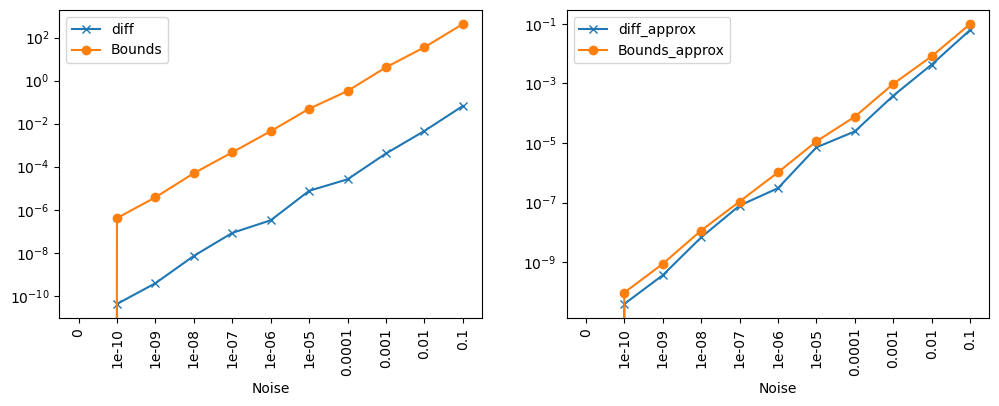

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(differences,marker='x',label="diff")
plt.plot(bounds,marker='o',label="Bounds")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()
plt.subplot(1,2,2)
plt.plot(differences_approx,marker='x',label="diff_approx")
plt.plot(bounds_approx,marker='o',label="Bounds_approx")
plt.xticks(np.arange(len(noise_levels)),noise_levels,rotation=90)
plt.yscale('log')
plt.xlabel('Noise')
plt.legend()

### Threshold for $g(A) = \frac{\sigma_n}{\|A\|_F}$

#### Non uniqueness

We assume $\sigma_n=0$. Denote the singular value of $\tilde{A}=A+E$ by  $\tilde{\sigma}_n$ and $G=(u|u_x)$.
 $$\frac{\tilde{\sigma}_n}{\|\tilde{G}\|_F} \leq \frac{\sigma_n + \|G-\tilde{G}\|_F}{\|\tilde{G}\|_F} \leq  \frac{ \sqrt{C}}{\|\tilde{G}\|_F} = T_1$$
where $C = m(C_m \frac{\epsilon}{h} + h^{order} M C_a)^2 + \|u-\tilde{u}\|_2^2$ and $\epsilon = \|u-u_{noise}\|_{\infty} + 10^{-16}$ and $h=dx$. If a value is smaller than T_1, the function u should be nonunique. Note in the following we also use the threshold
$$T_2= \frac{\frac{\epsilon}{h} + h^{order} }{\|\tilde{G}\|_F}$$
where we ignore all constants and guess \epsilon, since we can not know these in practice.

In [16]:
def calc_threshold_nonunique_approx(frobenius_norm,eps,h,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    return (eps/h+h**order)/frobenius_norm

def calc_threshold_nonunique_exact(frobenius_norm,eps_two,eps_infty,h,number_datapoints,M,order=2): 
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    return np.sqrt(E)/frobenius_norm

In [17]:
n_samples=50
T,X,t,x = create_data_2d(T_start=-5, T_end=1, L_x_start=0,L_x_end=1, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)

dx=x[1]-x[0]

In [18]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
sv_max,sv_min=sv[0],sv[-1]
frobenius_norm_trueg = np.linalg.norm(true_g)
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_min/frobenius_norm_trueg:3.3e}")

M: 0.999997313237914
Singular values of g: (37.155627627115564, 33.45832236731433)
sv_max/sv_min: 6.692e-01


True ratio: 1.111e+00
Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
0
0.0
	  	 2 	 	 6.691e-01 	 8.330e-06 	 	 6.942e-05
	  	 3 	 	 6.692e-01 	 1.700e-07 	 	 2.125e-06
	  	 4 	 	 6.692e-01 	 3.469e-09 	 	 5.782e-09
	  	 5 	 	 6.692e-01 	 7.080e-11 	 	 5.902e-10
	  	 6 	 	 6.692e-01 	 1.445e-12 	 	 5.360e-13
	  	 7 	 	 6.692e-01 	 2.971e-14 	 	 6.850e-13
	  	 8 	 	 6.692e-01 	 8.194e-16 	 	 2.271e-14
	  	 9 	 	 6.692e-01 	 2.299e-16 	 	 1.468e-12


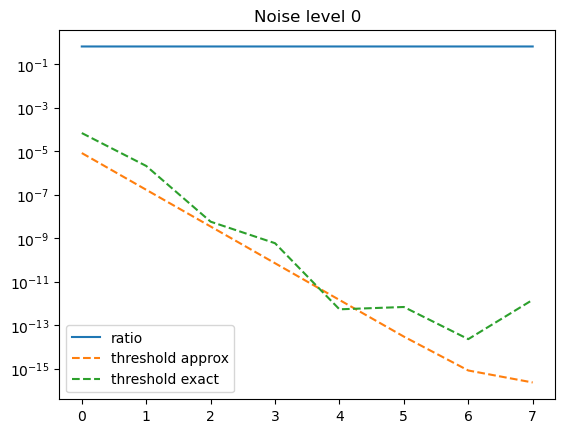

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-10
3.6833879626070004e-09
	  	 2 	 	 6.691e-01 	 8.330e-06 	 	 6.943e-05
	  	 3 	 	 6.692e-01 	 1.702e-07 	 	 2.203e-06
	  	 4 	 	 6.692e-01 	 3.704e-09 	 	 2.340e-08
	  	 5 	 	 6.692e-01 	 3.057e-10 	 	 2.010e-07
	  	 6 	 	 6.692e-01 	 2.363e-10 	 	 2.153e-08
	  	 7 	 	 6.692e-01 	 2.349e-10 	 	 5.404e-07
	  	 8 	 	 6.692e-01 	 2.349e-10 	 	 2.446e-08
	  	 9 	 	 6.692e-01 	 2.349e-10 	 	 1.584e-06


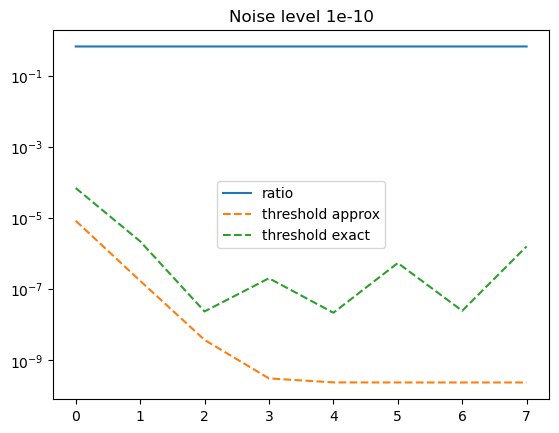

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-09
3.695036168446138e-08
	  	 2 	 	 6.691e-01 	 8.332e-06 	 	 6.953e-05
	  	 3 	 	 6.692e-01 	 1.723e-07 	 	 2.901e-06
	  	 4 	 	 6.692e-01 	 5.797e-09 	 	 1.804e-07
	  	 5 	 	 6.692e-01 	 2.399e-09 	 	 1.987e-06
	  	 6 	 	 6.692e-01 	 2.329e-09 	 	 2.134e-07
	  	 7 	 	 6.692e-01 	 2.328e-09 	 	 5.356e-06
	  	 8 	 	 6.692e-01 	 2.328e-09 	 	 2.425e-07
	  	 9 	 	 6.692e-01 	 2.328e-09 	 	 1.570e-05


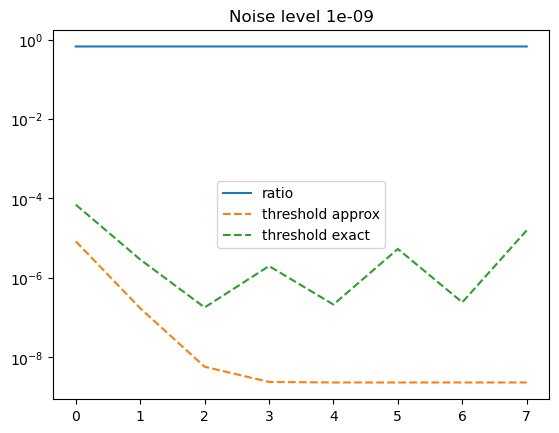

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-08
3.764835074358589e-07
	  	 2 	 	 6.691e-01 	 8.357e-06 	 	 7.075e-05
	  	 3 	 	 6.692e-01 	 1.967e-07 	 	 1.101e-05
	  	 4 	 	 6.692e-01 	 3.012e-08 	 	 2.005e-06
	  	 5 	 	 6.692e-01 	 2.673e-08 	 	 2.275e-05
	  	 6 	 	 6.692e-01 	 2.666e-08 	 	 2.443e-06
	  	 7 	 	 6.692e-01 	 2.666e-08 	 	 6.133e-05
	  	 8 	 	 6.692e-01 	 2.666e-08 	 	 2.777e-06
	  	 9 	 	 6.692e-01 	 2.666e-08 	 	 1.798e-04


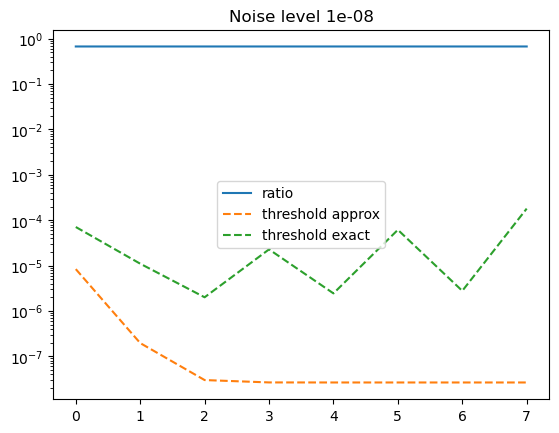

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-07
3.621500650142019e-06
	  	 2 	 	 6.691e-01 	 8.624e-06 	 	 8.410e-05
	  	 3 	 	 6.692e-01 	 4.637e-07 	 	 1.000e-04
	  	 4 	 	 6.692e-01 	 2.971e-07 	 	 2.203e-05
	  	 5 	 	 6.692e-01 	 2.938e-07 	 	 2.506e-04
	  	 6 	 	 6.692e-01 	 2.937e-07 	 	 2.692e-05
	  	 7 	 	 6.692e-01 	 2.937e-07 	 	 6.757e-04
	  	 8 	 	 6.692e-01 	 2.937e-07 	 	 3.059e-05
	  	 9 	 	 6.692e-01 	 2.937e-07 	 	 1.981e-03


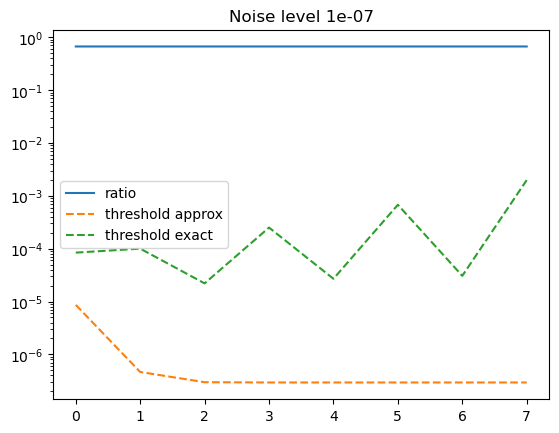

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-06
3.7319938880930764e-05
	  	 2 	 	 6.691e-01 	 1.093e-05 	 	 1.994e-04
	  	 3 	 	 6.692e-01 	 2.769e-06 	 	 8.684e-04
	  	 4 	 	 6.692e-01 	 2.602e-06 	 	 1.949e-04
	  	 5 	 	 6.692e-01 	 2.599e-06 	 	 2.218e-03
	  	 6 	 	 6.692e-01 	 2.599e-06 	 	 2.382e-04
	  	 7 	 	 6.692e-01 	 2.599e-06 	 	 5.980e-03
	  	 8 	 	 6.692e-01 	 2.599e-06 	 	 2.707e-04
	  	 9 	 	 6.692e-01 	 2.599e-06 	 	 1.753e-02


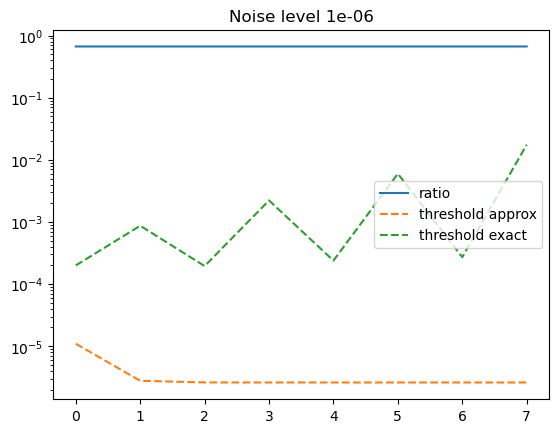

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
1e-05
0.00036534808153455947
	  	 2 	 	 6.691e-01 	 3.241e-05 	 	 1.273e-03
	  	 3 	 	 6.692e-01 	 2.424e-05 	 	 8.027e-03
	  	 4 	 	 6.692e-01 	 2.408e-05 	 	 1.806e-03
	  	 5 	 	 6.692e-01 	 2.407e-05 	 	 2.054e-02
	  	 6 	 	 6.692e-01 	 2.407e-05 	 	 2.207e-03
	  	 7 	 	 6.692e-01 	 2.407e-05 	 	 5.539e-02
	  	 8 	 	 6.692e-01 	 2.407e-05 	 	 2.508e-03
	  	 9 	 	 6.692e-01 	 2.407e-05 	 	 1.624e-01


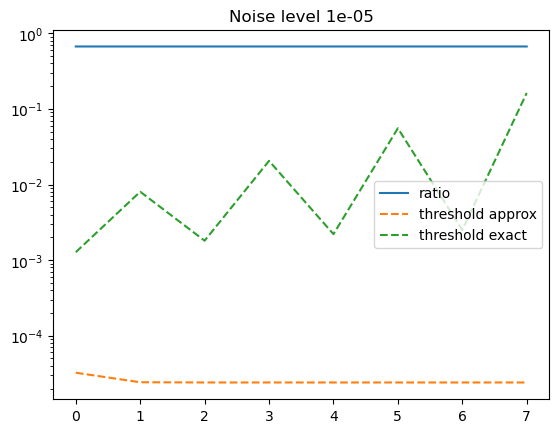

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
0.0001
0.0037609290587725126
	  	 2 	 	 6.692e-01 	 2.553e-04 	 	 1.242e-02
	  	 3 	 	 6.692e-01 	 2.471e-04 	 	 8.232e-02
	  	 4 	 	 6.692e-01 	 2.469e-04 	 	 1.852e-02
	  	 5 	 	 6.692e-01 	 2.469e-04 	 	 2.107e-01
	  	 6 	 	 6.693e-01 	 2.469e-04 	 	 2.264e-02
	  	 7 	 	 6.694e-01 	 2.469e-04 	 	 5.681e-01
	  	 8 	 	 6.696e-01 	 2.468e-04 	 	 2.571e-02
	  	 9 	 	 6.702e-01 	 2.467e-04 	 	 1.664e+00


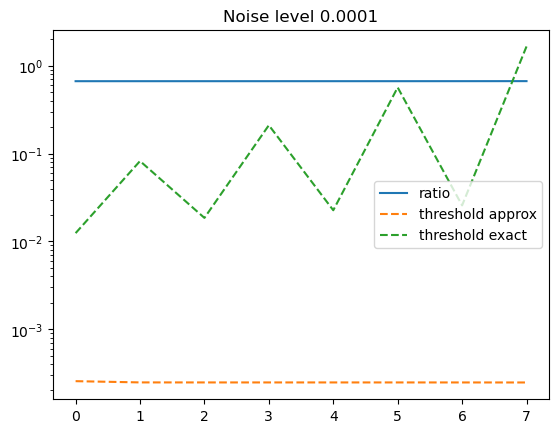

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
0.001
0.03694695471642415
	  	 2 	 	 6.698e-01 	 2.482e-03 	 	 1.237e-01
	  	 3 	 	 6.705e-01 	 2.471e-03 	 	 8.237e-01
	  	 4 	 	 6.706e-01 	 2.471e-03 	 	 1.853e-01
	  	 5 	 	 6.716e-01 	 2.467e-03 	 	 2.106e+00
	  	 6 	 	 6.734e-01 	 2.462e-03 	 	 2.256e-01
	  	 7 	 	 6.785e-01 	 2.444e-03 	 	 5.624e+00
	  	 8 	 	 6.906e-01 	 2.400e-03 	 	 2.500e-01
	  	 9 	 	 6.819e-01 	 2.284e-03 	 	 1.541e+01


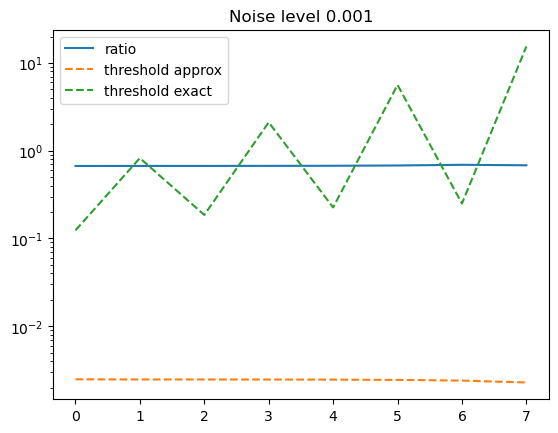

Noise level 	 order 	 	 ratio 	 	 threshold approx 	 threshold exact
0.01
0.3768408191951929
	  	 2 	 	 6.992e-01 	 3.082e-02 	 	 1.541e+00
	  	 3 	 	 6.636e-01 	 2.886e-02 	 	 9.621e+00
	  	 4 	 	 6.569e-01 	 2.856e-02 	 	 2.142e+00
	  	 5 	 	 5.981e-01 	 2.600e-02 	 	 2.219e+01
	  	 6 	 	 5.197e-01 	 2.259e-02 	 	 2.071e+00
	  	 7 	 	 3.941e-01 	 1.713e-02 	 	 3.941e+01
	  	 8 	 	 2.674e-01 	 1.162e-02 	 	 1.210e+00
	  	 9 	 	 1.665e-01 	 7.234e-03 	 	 4.880e+01


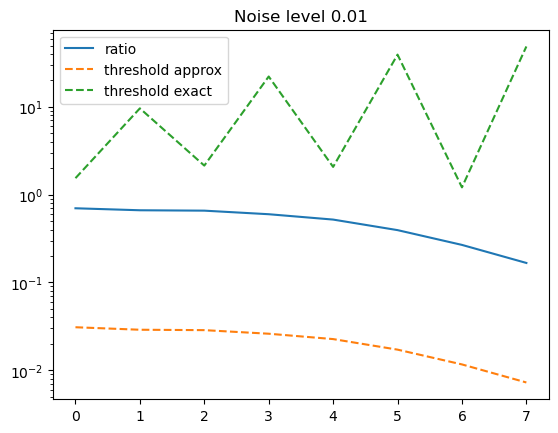

In [19]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold approx \t threshold exact")
    print(f"{target_noise}")
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_infty = infinity_norm(u-u_noise)
    eps_two = np.linalg.norm(u-u_noise)
    
    for order in orders:          
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise = np.linalg.norm(g_noise)
        ratio=sv[-1]/frobenius_norm_gnoise
        
        threshold = calc_threshold_nonunique_approx(frobenius_norm_gnoise,eps_infty,dx,order)
        threshold_list.append(threshold)
        threshold2 = calc_threshold_nonunique_exact(frobenius_norm_gnoise,eps_two,eps_infty,dx,true_g.shape[0],M,order)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)
                                               
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t {threshold:3.3e} \t \t {threshold2:3.3e}")

    plt.title(f"Noise level {target_noise}")
    plt.plot(ratio_list,label='ratio')
    plt.plot(threshold_list,'--',label='threshold approx')
    plt.plot(threshold2_list,'--',label='threshold exact')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Uniqueness

##### We try a threshold for unqiue values
We choose $C>0$ such that $\sigma_n \geq C$. Then
$$\frac{\tilde\sigma_n}{\|\tilde{G}\|} \geq \frac{\sigma_n -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\|\tilde{G}-G\|}{\|\tilde{G}\|} \geq \frac{C -\sqrt{E}}{\|\tilde{G}\|}$$
The ideal $C$ would be $C = \sigma_n$. However, in practice we do not know the true singular valuse. Thus, we can educately guess with:
$$C =\tilde\sigma_n-\sqrt{eps/h+h^{order}}$$
This approximates deviation we get from the derivative calculation.

In [20]:
"""
u: function with noise
eps: noise estimation infinity_norm(u-u_noise)
"""
def educated_guess_c(u,eps,h):
    #Calculate omin omax
    order=2
    ux= ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u, h)
    u_flat, u_x_flat = u.flatten(), ux.flatten()
    g = np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
    omin = svd(g, compute_uv=False)[-1]
    #Calculate C  
    print(eps,h,order)
    E = (eps/h+h**order)
    print(omin,E)
    assert omin - np.sqrt(E) >0
    C = max(omin - np.sqrt(E) , 1e-14)
    return C

"""
This calculates the threshold with minimal knowlegdede
C: lower bound on >= C
eps: noise estimation infinity_norm(u-u_noise)
h: dx
order: order of the derivative caluclation
"""
def calc_threshold_uniq_approx(C,frobenius_norm,eps,h,order=2):
    E = (eps/h+h**order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T
##This function calculates the threshold with all constants (we do not normally know)
def calc_threshold_uniq_exact(C,frobenius_norm,eps_two,eps_infty,M,h,number_datapoints,order=2):
    E = error_bound_g(eps_two,eps_infty,h,number_datapoints,M,order)
    #assert C-np.sqrt(E) >0
    T = max((C-np.sqrt(E))/frobenius_norm,1e-13)
    return T

In [21]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()*1e-6
b=np.random.randn()*1e-3
C=0.1

u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C
"""

u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut

u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u
"""
dx=x[1]-x[0]

In [22]:
u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 0.099979594612992
Singular values of g: (7.7034697442346785, 6.376249203070793)
sv_max/sv_min: 0.770


In [23]:
#Best choice C1 C2
C=sv_min
print(f"C: {C}")

C: 6.376249203070793


True ratio: 1.208e+00
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
0.0 0.05050505050505061 2
6.375683068811567 0.0025507601265177125
C: 6.3251780183065165, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


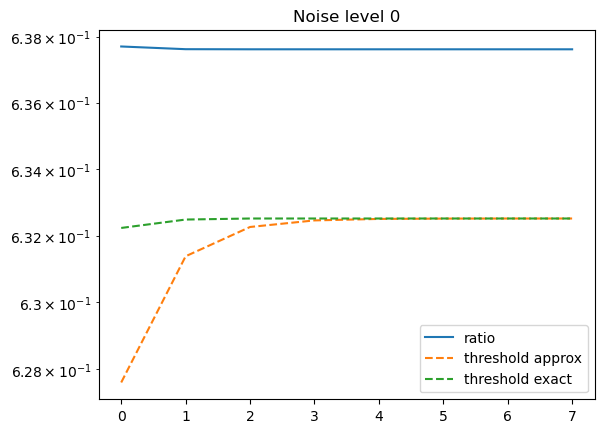

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
6.713871792225703e-10
2.507193758161108e-11 0.05050505050505061 2
6.375683068803994 0.002550760622942077
C: 6.325178013384343, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


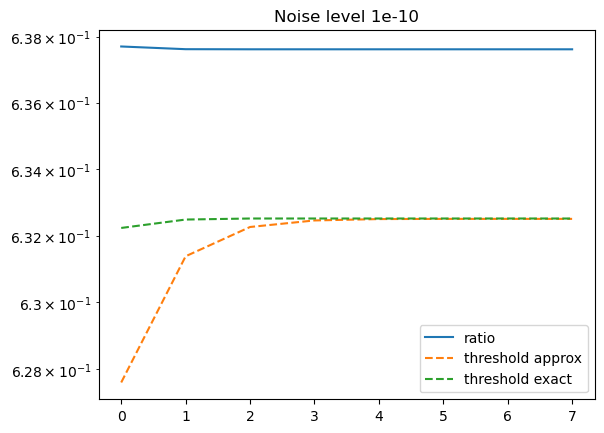

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-09
6.690558659049438e-09
2.3772707413716176e-10 0.05050505050505061 2
6.375683068851986 0.0025507648335137806
C: 6.325177971747696, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.323e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.325e-01 	 	 6.325e-01


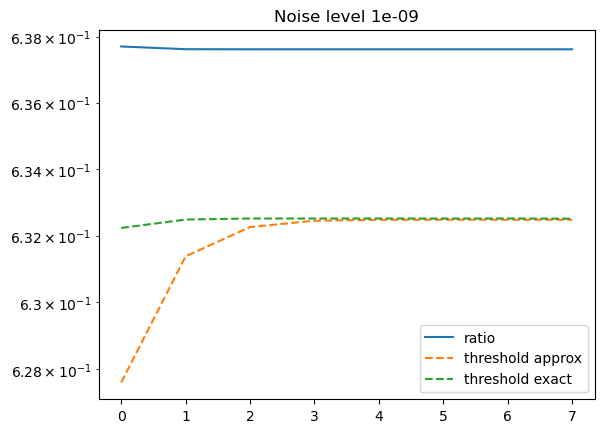

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-08
6.58449645861229e-08
2.559793460532589e-09 0.05050505050505061 2
6.375683065337172 0.002550810810428231
C: 6.3251775130639, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.314e-01 	 	 6.325e-01
	  	 4 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 6 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 8 	 	 6.376e-01 	 	 6.324e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.324e-01 	 	 6.324e-01


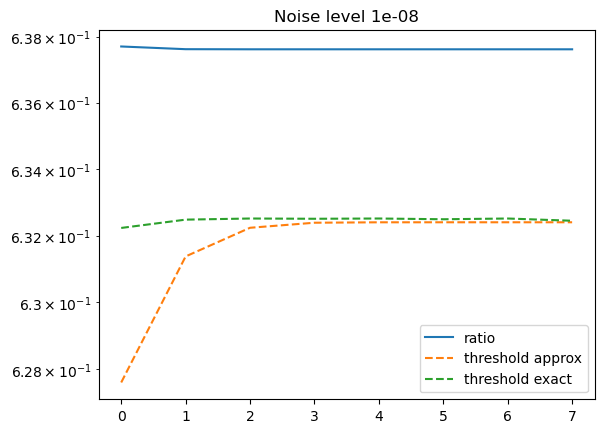

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-07
6.683202220345516e-07
2.9831780420930265e-08 0.05050505050505061 2
6.375683071245736 0.002551350795770047
C: 6.325172173453576, Check 
	  	 2 	 	 6.377e-01 	 	 6.276e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.313e-01 	 	 6.324e-01
	  	 4 	 	 6.376e-01 	 	 6.321e-01 	 	 6.325e-01
	  	 5 	 	 6.376e-01 	 	 6.321e-01 	 	 6.324e-01
	  	 6 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 7 	 	 6.376e-01 	 	 6.322e-01 	 	 6.322e-01
	  	 8 	 	 6.376e-01 	 	 6.322e-01 	 	 6.325e-01
	  	 9 	 	 6.376e-01 	 	 6.322e-01 	 	 6.317e-01


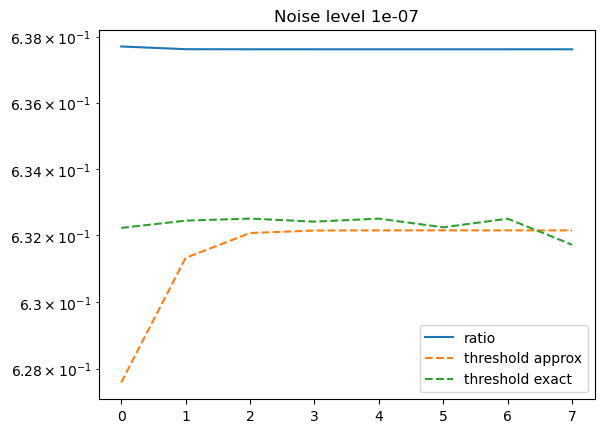

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-06
6.713387237317534e-06
2.381292346330388e-07 0.05050505050505061 2
6.375683123350268 0.0025554750853634465
C: 6.32513141630329, Check 
	  	 2 	 	 6.377e-01 	 	 6.275e-01 	 	 6.322e-01
	  	 3 	 	 6.376e-01 	 	 6.309e-01 	 	 6.322e-01
	  	 4 	 	 6.376e-01 	 	 6.313e-01 	 	 6.324e-01
	  	 5 	 	 6.376e-01 	 	 6.314e-01 	 	 6.317e-01
	  	 6 	 	 6.376e-01 	 	 6.314e-01 	 	 6.324e-01
	  	 7 	 	 6.376e-01 	 	 6.314e-01 	 	 6.303e-01
	  	 8 	 	 6.376e-01 	 	 6.314e-01 	 	 6.324e-01
	  	 9 	 	 6.376e-01 	 	 6.314e-01 	 	 6.262e-01


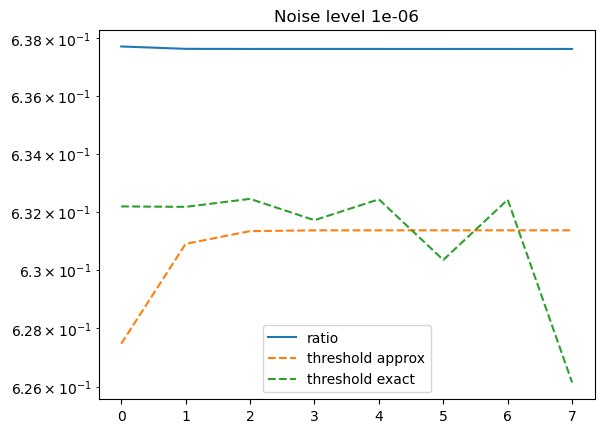

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-05
6.781493575016073e-05
2.7953908654961e-06 0.05050505050505061 2
6.375682809237663 0.0026061088656545352
C: 6.324632746890448, Check 
	  	 2 	 	 6.377e-01 	 	 6.264e-01 	 	 6.316e-01
	  	 3 	 	 6.376e-01 	 	 6.286e-01 	 	 6.287e-01
	  	 4 	 	 6.376e-01 	 	 6.288e-01 	 	 6.316e-01
	  	 5 	 	 6.376e-01 	 	 6.288e-01 	 	 6.230e-01
	  	 6 	 	 6.376e-01 	 	 6.288e-01 	 	 6.314e-01
	  	 7 	 	 6.376e-01 	 	 6.288e-01 	 	 6.070e-01
	  	 8 	 	 6.376e-01 	 	 6.288e-01 	 	 6.313e-01
	  	 9 	 	 6.376e-01 	 	 6.288e-01 	 	 5.578e-01


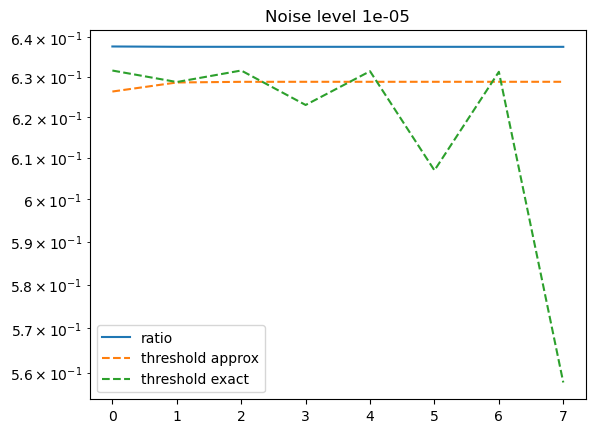

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.0001
0.0006731550321667238
2.4764594954262975e-05 0.05050505050505061 2
6.3757346338816 0.0030410991066121187
C: 6.320588472577189, Check 
	  	 2 	 	 6.377e-01 	 	 6.196e-01 	 	 6.269e-01
	  	 3 	 	 6.376e-01 	 	 6.205e-01 	 	 5.993e-01
	  	 4 	 	 6.376e-01 	 	 6.205e-01 	 	 6.247e-01
	  	 5 	 	 6.376e-01 	 	 6.205e-01 	 	 5.484e-01
	  	 6 	 	 6.376e-01 	 	 6.205e-01 	 	 6.231e-01
	  	 7 	 	 6.376e-01 	 	 6.205e-01 	 	 4.064e-01
	  	 8 	 	 6.376e-01 	 	 6.205e-01 	 	 6.219e-01
	  	 9 	 	 6.376e-01 	 	 6.206e-01 	 	 1.000e-13


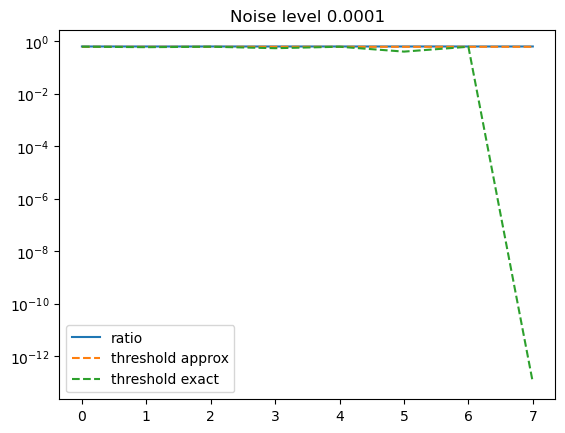

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.001
0.006731351972078804
0.00024547984056634553 0.05050505050505061 2
6.375673059930325 0.007411260969731345
C: 6.289584379084749, Check 
	  	 2 	 	 6.377e-01 	 	 5.922e-01 	 	 5.800e-01
	  	 3 	 	 6.376e-01 	 	 5.924e-01 	 	 3.049e-01
	  	 4 	 	 6.376e-01 	 	 5.924e-01 	 	 5.560e-01
	  	 5 	 	 6.375e-01 	 	 5.923e-01 	 	 1.000e-13
	  	 6 	 	 6.375e-01 	 	 5.921e-01 	 	 5.395e-01
	  	 7 	 	 6.375e-01 	 	 5.916e-01 	 	 1.000e-13
	  	 8 	 	 6.371e-01 	 	 5.906e-01 	 	 5.260e-01
	  	 9 	 	 6.360e-01 	 	 5.878e-01 	 	 1.000e-13


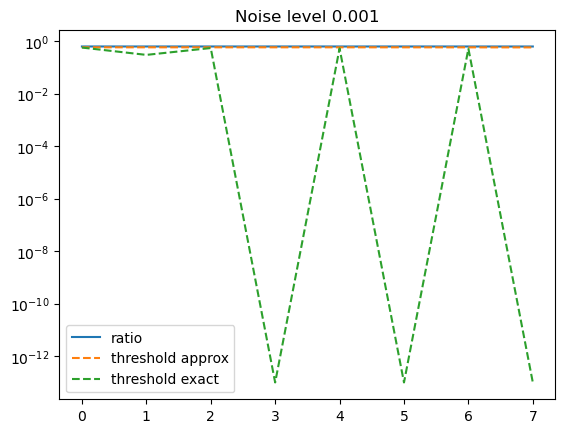

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0.01
0.06617695330522953
0.002843060562740316 0.05050505050505061 2
6.392174077458075 0.058843359268775854
C: 6.149597575568928, Check 
	  	 2 	 	 6.361e-01 	 	 4.979e-01 	 	 5.132e-02
	  	 3 	 	 6.334e-01 	 	 4.935e-01 	 	 1.000e-13
	  	 4 	 	 6.334e-01 	 	 4.939e-01 	 	 1.000e-13
	  	 5 	 	 6.295e-01 	 	 4.883e-01 	 	 1.000e-13
	  	 6 	 	 6.238e-01 	 	 4.817e-01 	 	 1.000e-13
	  	 7 	 	 6.059e-01 	 	 4.635e-01 	 	 1.000e-13
	  	 8 	 	 5.623e-01 	 	 4.257e-01 	 	 1.000e-13
	  	 9 	 	 4.670e-01 	 	 3.507e-01 	 	 1.000e-13


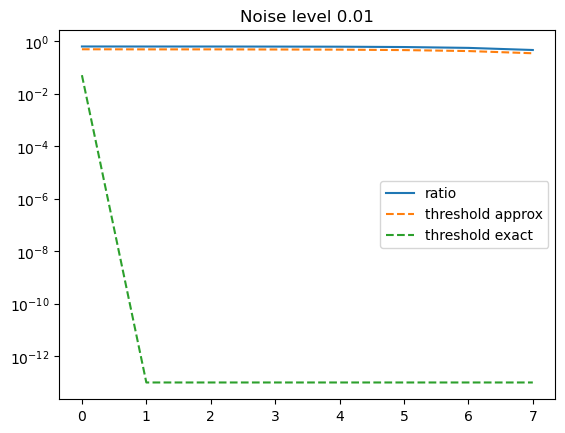

In [27]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))

for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_list = []
    threshold2_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise        
        threshold = calc_threshold_uniq_approx(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2 = calc_threshold_uniq_exact(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_list.append(threshold)
        threshold2_list.append(threshold2)
        ratio_list.append(ratio)

        
        print(f"\t  \t {order} \t \t {ratio:3.3e} \t \t {threshold:3.3e} \t \t {threshold2:3.3e}")
    
    plt.title(f"Noise level {target_noise}")
    plt.plot(ratio_list,label='ratio')
    plt.plot(threshold_list,'--',label='threshold approx')
    plt.plot(threshold2_list,'--',label='threshold exact')
    plt.yscale('log')
    plt.legend()
    plt.show()

### Combine non uniqueness and uniqueness bound

In [28]:
n_samples=100
T,X,t,x = create_data_2d(T_start=0, T_end=1, L_x_start=-2,L_x_end=3, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
b=np.random.randn()
C=1
"""
u = np.cos(X-a*T)*C
ux = -np.sin(X-a*T)*C
uxx = -np.cos(X-a*T)*C
uxxx = np.sin(X-a*T)*C
ut = a*np.sin(X-a*T)*C


u=(X+b*T)*np.exp(a*T)
ux = np.exp(a*T)
uxx= 1
uxxx= 0
ut= b*np.exp(a*T) + a*(X*+b*T)*np.exp(a*T) #bux + aut
"""
u = np.exp(X-a*T)
ux = u
uxx = u
uxxx = u
ut = -a*u

dx=x[1]-x[0]

u_flat, ux_flat = u.flatten(), ux.flatten()
true_g = np.concatenate([u_flat.reshape(len(u_flat),1), ux_flat.reshape(len(ux_flat),1)], axis=1)
sv = svd(true_g, compute_uv=False)
frobenius_norm_trueg = np.linalg.norm(true_g)
sv_max,sv_min=sv[0],sv[-1]
print(f"M: {np.max(u)}")
print(f"Singular values of g: {sv_max,sv_min}")
print(f"sv_max/sv_min: {sv_max/frobenius_norm_trueg:3.3f}")

M: 20.085536923187668
Singular values of g: (560.2333647250176, 1.3972334827277449e-14)
sv_max/sv_min: 1.000


True ratio: 4.010e+16
Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
0
0.0
C: 1.3972334827277449e-14, Check 


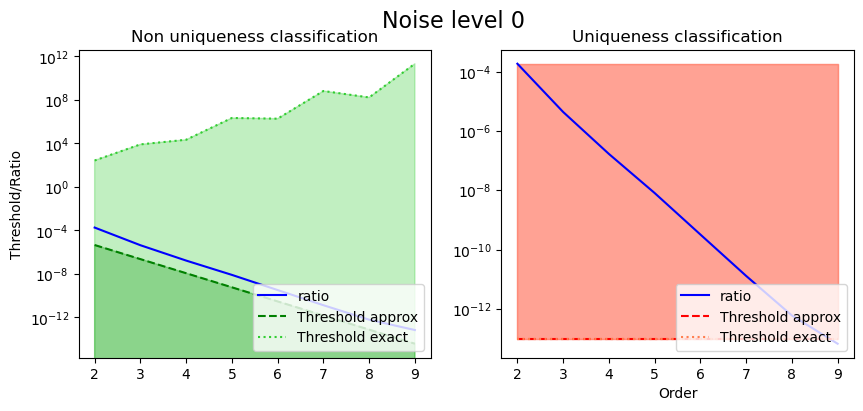

Noise level 	 order 	 	 ratio 	 	 threshold 	 threshold2
1e-10
3.991001076951091e-08
C: 1.3972334827277449e-14, Check 


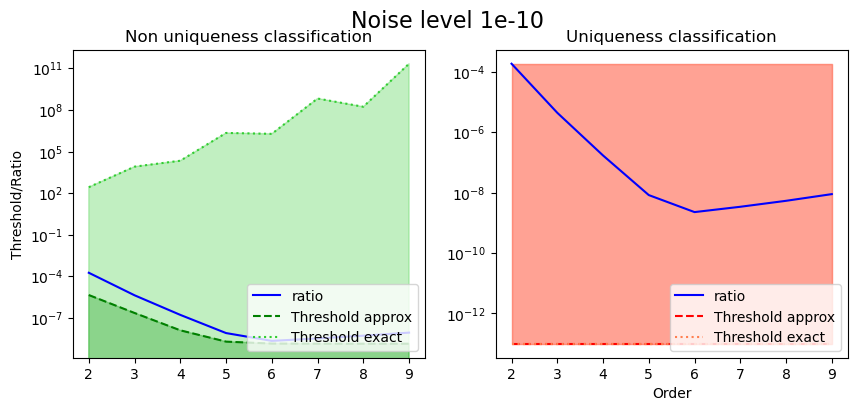

In [29]:
M=infinity_norm(uxxx)
number_noise=2 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(2,10,1)
print(f"True ratio: {sv_max/sv_min:3.3e}")
unorm2=np.sqrt(np.mean(np.square(u)))
C=sv_min
for target_noise in noise_levels:
    print("Noise level \t order \t \t ratio \t \t threshold \t threshold2")
    print(f"{target_noise}")
    
    threshold_uniq_list = []
    threshold2_uniq_list = []
    threshold_nonunique_list = []
    threshold2_nonunique_list = []
    ratio_list=[]
    
    var = target_noise * unorm2
    noise = np.random.normal(0, var, size=u.shape)
    print(np.linalg.norm(noise))
    u_noise = u + noise
    eps_two = np.linalg.norm(u-u_noise)
    eps_infty = infinity_norm(u-u_noise)

    #Educated guess for C1 C2
    #C = educated_guess_c(u_noise,eps_infty,dx)
    print(f"C: {C}, Check ")
    for order in orders:        
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        u_flat_noise, u_x_flat_noise = u_noise.flatten(), ux_noise.flatten()
        g_noise = np.concatenate([u_flat_noise.reshape(len(u_flat_noise),1), u_x_flat_noise.reshape(len(u_flat_noise),1)], axis=1)
        sv = svd(g_noise, compute_uv=False)
        frobenius_norm_gnoise=np.linalg.norm(g_noise)
        
        ratio=sv[-1]/frobenius_norm_gnoise   
        
        threshold_uniq = calc_threshold_uniq_approx(C,frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_uniq = calc_threshold_uniq_exact(C,frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_uniq_list.append(threshold_uniq)
        threshold2_uniq_list.append(threshold2_uniq)
  
        threshold_nonunique = calc_threshold_nonunique_approx(frobenius_norm_gnoise,eps_two,dx,order)
        threshold2_nonunique = calc_threshold_nonunique_exact(frobenius_norm_gnoise,eps_two,eps_infty,M,dx,true_g.shape[0],order)
        threshold_nonunique_list.append(threshold_nonunique)
        threshold2_nonunique_list.append(threshold2_nonunique)
        
        ratio_list.append(ratio)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
    fig.suptitle(f'Noise level {target_noise}', fontsize=16)
    
    # Subplot 1: ratio and green lines
    ax1.set_title("Non uniqueness classification")
    ax1.plot(orders, ratio_list, label='ratio', color='blue')
    ax1.plot(orders, threshold_nonunique_list, '--', label='Threshold approx', color='green')
    ax1.plot(orders, threshold2_nonunique_list, ':', label='Threshold exact', color='limegreen')
    ax1.fill_between(orders, threshold_nonunique_list, color='green', alpha=0.3)
    ax1.fill_between(orders, threshold2_nonunique_list, color='limegreen', alpha=0.3)
    ax1.set_yscale('log')
    ax1.set_ylabel('Threshold/Ratio')
    
    # Subplot 2: ratio and red lines
    ax2.set_title("Uniqueness classification")
    ax2.plot(orders, ratio_list, label='ratio', color='blue')
    ax2.plot(orders, threshold_uniq_list, '--', label='Threshold approx', color='red')
    ax2.plot(orders, threshold2_uniq_list, ':', label='Threshold exact', color='coral')
    ax2.fill_between(orders, threshold_uniq_list, y2=np.max(ratio_list), color='red', alpha=0.3)
    ax2.fill_between(orders, threshold2_uniq_list, y2=np.max(ratio_list), color='coral', alpha=0.3)
    ax2.set_yscale('log')

    
    ax2.set_xlabel('Order')
    ax1.legend(loc=4)
    ax2.legend(loc=4)
    
    plt.show()